# NLP Coursework - Sentiment Analysis IMDB
#### Youssef Abdelmoamen - UG
#### 190054712


## Import Libraries

In [2]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

import os

## Mount Google Drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


## Import The Dataset

In [4]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP_CW_Folder/IMDB_Dataset.csv')

## Exploratory Data Analysis

In [5]:
df.shape #Check to see the exact shape of the IMDB dataset

(50000, 2)

In [6]:
df.head(10) #Check for the first 10 values in the IMDB dataset

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [7]:
#Check the columns for na values
for column in df.columns:
  print(column)
  print(pd.isna(df[column]).sum())

review
0
sentiment
0


In [8]:
df.describe() #Describe the data

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [9]:
df.duplicated().sum() #Check for duplicate rows/reviews

418

In [10]:
df['sentiment'].value_counts() #count the value of each sentiment (equal values)

positive    25000
negative    25000
Name: sentiment, dtype: int64

## Preprocessing The data

###**Lowercase the text**

In [11]:
df['review']=df['review'].str.lower()

###**Remove HTML tags, punctuation, special characters and other noisy text** 

In [12]:
def remove_html_and_noise(t):
  #start by removing the HTML tags
  t = BeautifulSoup(t, "html.parser").get_text()

  #then remove all the noisy text
  t = re.sub(r'\[[^]]*\]', '', t) #remove the square brackets 

  #remove any character that is not uppercase, lowercase, a digit or whitespace
  t = re.sub(r'[^a-zA-Z0-9\s]', '', t)  

  return t

df['review']=df['review'].apply(remove_html_and_noise) #Apply to all the reviews

<ipython-input-12-453cd35a1461>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  t = BeautifulSoup(t, "html.parser").get_text()


### **Normalization**



#### Remove stopwords

In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))#set of English stopwords from NLTK

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
#Removes stopwords from the given text and returns the filtered text.
def remove_stopwords(t):
    tokens = t.split()  #Split the text into tokens
    tokens_filtered = [token.strip(string.punctuation) for token in tokens if token.strip(string.punctuation).lower() not in stop_words] #Filter out stopwords
    text_filtered = " ".join(tokens_filtered)  #Join filtered tokens back into text
    return text_filtered

# example usage:
text = "this is a sample sentence with some stopwords such as the, and, and a."
text_filtered = remove_stopwords(text)
print(text_filtered)  #It should print "sample sentence stopwords"
df['review']=df['review'].apply(remove_stopwords)#Apply to all the reviews

sample sentence stopwords


#### Lemmatization

In [15]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    #Map POS tag to first character used by WordNetLemmatizer
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(t):
    #Lemmatize the given text and returns the lemmatized text.
    tokens = nltk.word_tokenize(t)  # tokenize text
    tokens_lemmatized = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]  #Lemmatize tokens
    text_lemmatized = " ".join(tokens_lemmatized)  #Join lemmatized tokens back into text
    return text_lemmatized

# example usage:
t = "I am running in the park and eating an apple."
text_lemmatized = lemmatize(t)
print(text_lemmatized)  #It should print "I be run in the park and eat an apple ."
df['review']=df['review'].apply(lemmatize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


I be run in the park and eat an apple .


## Split data into Train/Test

In [16]:
#Split the data into train and testing using sklearn's train_test_split
train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)


In [17]:
print(train_reviews.shape, train_sentiments.shape, test_reviews.shape, test_sentiments.shape)

(40000,) (40000,) (10000,) (10000,)


## Feature Engineering




####**Bag Of Words**

In [18]:
#Create object for the CountVectorizer
vectorizer_cv = CountVectorizer()

#Fit and transform the training reviews
train_transformed_cv = vectorizer_cv.fit_transform(train_reviews)

#Transform the test reviews 
test_transformed_cv = vectorizer_cv.transform(test_reviews)

print(train_transformed_cv.shape)
print(test_transformed_cv.shape)

(40000, 174898)
(10000, 174898)


####**Term Frequency-Inverse Document Frequency (TF-IDF)**

In [19]:
#Tfidf vectorizer
vectorizer_tf = TfidfVectorizer()
#Fit and transform the training reviews
train_transformed_tf=vectorizer_tf.fit_transform(train_reviews)
#Transform test reviews
test_transformed_tf=vectorizer_tf.transform(test_reviews)
print(train_transformed_tf.shape)
print(test_transformed_tf.shape)

(40000, 174898)
(10000, 174898)


###**Convert sentiment data to binary**

In [20]:
#convert the categorical sentiment data (positive/negative) to binary labels (1/0)
categorical_to_binary = LabelBinarizer()
#Fit and Transform the training sentiments to binary
train_sentiments=categorical_to_binary.fit_transform(train_sentiments)
#Transform the test sentiments to binary
test_sentiments=categorical_to_binary.transform(test_sentiments)
#print the shapes of train sentiments and test sentiments
print(train_sentiments.shape)
print(test_sentiments.shape)

(40000, 1)
(10000, 1)


## Model Development and Evaluation

###**Logistic Regression**

In [21]:
# Initialize logistic regression model
model = LogisticRegression()

# Train the model on the training reviews that were transformed using the Bag Of Words model
cv_model = model.fit(train_transformed_cv, train_sentiments)

#Train model on training reviews that were transformed using the TF-IDF model
tf_model = model.fit(train_transformed_tf, train_sentiments)

#Predict sentiment labels for the test reviews that were transformed using the Bag Of Words model
test_pred_cv = model.predict(test_transformed_cv)

#Predict sentiment labels for the test reviews that were transformed using the TF-IDF model
test_pred_tf= model.predict(test_transformed_tf)

#Evaluate the performance of the model on the test data (Bag of Words)
accuracy_cv = accuracy_score(test_sentiments, test_pred_cv)

#Evaluate the performance of the model on the test data (TF-IDF)
accuracy_tf = accuracy_score(test_sentiments, test_pred_tf)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

In [22]:
#print the accuracy of each model
print("Logistic Regression Accuracy (Bag Of Words):", accuracy_cv)
print("Logistic Regression Accuracy (TF-IDF):", accuracy_tf)

Logistic Regression Accuracy (Bag Of Words): 0.87
Logistic Regression Accuracy (TF-IDF): 0.891


### **Evaluation Of Logistic Regression Model** 

In [23]:
#Classification report for Logistic regression/Bag of Words model
print("Bag of Words model:\n", classification_report(test_sentiments, test_pred_cv))

#Classification report for Logistic Regression/TF-IDF model
print("TF-IDF model:\n", classification_report(test_sentiments, test_pred_tf))


Bag of Words model:
               precision    recall  f1-score   support

           0       0.90      0.83      0.86      4961
           1       0.84      0.91      0.88      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

TF-IDF model:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



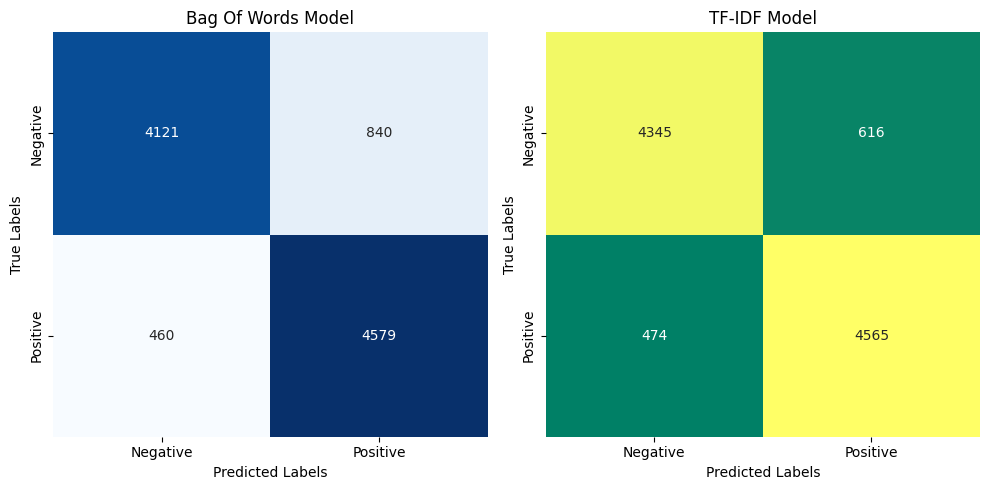

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Confusion matrix for Bag Of Words model
cm_cv = confusion_matrix(test_sentiments, test_pred_cv)
sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axs[0])
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('True Labels')
axs[0].set_title('Bag Of Words Model')

# Confusion matrix for TF-IDF model
cm_tf = confusion_matrix(test_sentiments, test_pred_tf)
sns.heatmap(cm_tf, annot=True, fmt='d', cmap='summer', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axs[1])
axs[1].set_xlabel('Predicted Labels')
axs[1].set_ylabel('True Labels')
axs[1].set_title('TF-IDF Model')

plt.tight_layout()
plt.show()


### **Naive Bayes Classifier Model**

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

#Create the Naive Bayes classifier object
model_NB = MultinomialNB()

#Train the model on the training reviews that were transformed using the Bag Of Words model
cv_model_NB = model_NB.fit(train_transformed_cv, train_sentiments)

#Train model on training reviews that were transformed using the TF-IDF model
tf_model_NB = model_NB.fit(train_transformed_tf, train_sentiments)

#Predict sentiment labels for the test reviews that were transformed using the Bag Of Words model
test_pred_cv_NB = model_NB.predict(test_transformed_cv)

#Predict sentiment labels for the test reviews that were transformed using the TF-IDF model
test_pred_tf_NB= model_NB.predict(test_transformed_tf)

#Evaluate the performance of the model on the test data (Bag of Words)
accuracy_cv_NB = accuracy_score(test_sentiments, test_pred_cv_NB)

#Evaluate the performance of the model on the test data (TF-IDF)
accuracy_tf_NB = accuracy_score(test_sentiments, test_pred_tf_NB)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
#print the accuracy of each model
print("Naive Bayes Classifier Accuracy (Bag Of Words):", accuracy_cv_NB)
print("Naive Bayes Classifier Accuracy (TF-IDF):", accuracy_tf_NB)

Naive Bayes Classifier Accuracy (Bag Of Words): 0.8564
Naive Bayes Classifier Accuracy (TF-IDF): 0.8629


### **Naive Bayes classifier Model Evaluation**

In [27]:
#Classification report for Logistic regression/Bag of Words model
print("Bag of Words model:\n", classification_report(test_sentiments, test_pred_cv_NB))

#Classification report for Logistic Regression/TF-IDF model
print("TF-IDF model:\n", classification_report(test_sentiments, test_pred_tf_NB))

Bag of Words model:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      4961
           1       0.90      0.81      0.85      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

TF-IDF model:
               precision    recall  f1-score   support

           0       0.85      0.88      0.86      4961
           1       0.87      0.85      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



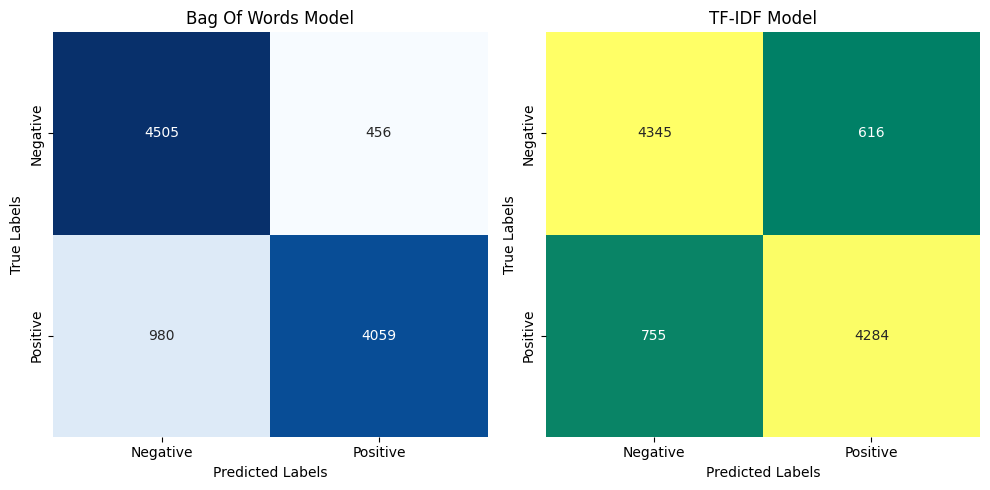

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Confusion matrix for Bag Of Words model
cm_cv = confusion_matrix(test_sentiments, test_pred_cv_NB)
sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axs[0])
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('True Labels')
axs[0].set_title('Bag Of Words Model')

# Confusion matrix for TF-IDF model
cm_tf = confusion_matrix(test_sentiments, test_pred_tf_NB)
sns.heatmap(cm_tf, annot=True, fmt='d', cmap='summer', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axs[1])
axs[1].set_xlabel('Predicted Labels')
axs[1].set_ylabel('True Labels')
axs[1].set_title('TF-IDF Model')

plt.tight_layout()
plt.show()

### **Support Vector Machine (SVM) Model**

In [29]:
from sklearn.svm import LinearSVC

# Initialize SVM model
svm_model = LinearSVC()

#Train the model on the training reviews that were transformed using the Bag Of Words model
cv_model_svm = svm_model.fit(train_transformed_cv, train_sentiments)

#Train model on training reviews that were transformed using the TF-IDF model
tf_model_svm = svm_model.fit(train_transformed_tf, train_sentiments)

#Predict sentiment labels for the test reviews that were transformed using the Bag Of Words model
test_pred_cv_svm = svm_model.predict(test_transformed_cv)

#Predict sentiment labels for the test reviews that were transformed using the TF-IDF model
test_pred_tf_svm= svm_model.predict(test_transformed_tf)

#Evaluate the performance of the model on the test data (Bag of Words)
accuracy_cv_svm = accuracy_score(test_sentiments, test_pred_cv_svm)

#Evaluate the performance of the model on the test data (TF-IDF)
accuracy_tf_svm = accuracy_score(test_sentiments, test_pred_tf_svm)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
#print the accuracy of each model
print("SVM Accuracy (Bag Of Words):", accuracy_cv_svm)
print("SVM Accuracy (TF-IDF):", accuracy_tf_svm)

SVM Accuracy (Bag Of Words): 0.8818
SVM Accuracy (TF-IDF): 0.8915


### **Support Vector Machine (SVM) Model Evaluation**


In [31]:
#Classification report for Logistic regression/Bag of Words model
print("Bag of Words model (SVM):\n", classification_report(test_sentiments, test_pred_cv_svm))

#Classification report for Logistic Regression/TF-IDF model
print("TF-IDF model (SVM):\n", classification_report(test_sentiments, test_pred_tf_svm))

Bag of Words model (SVM):
               precision    recall  f1-score   support

           0       0.92      0.84      0.88      4961
           1       0.85      0.92      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

TF-IDF model (SVM):
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



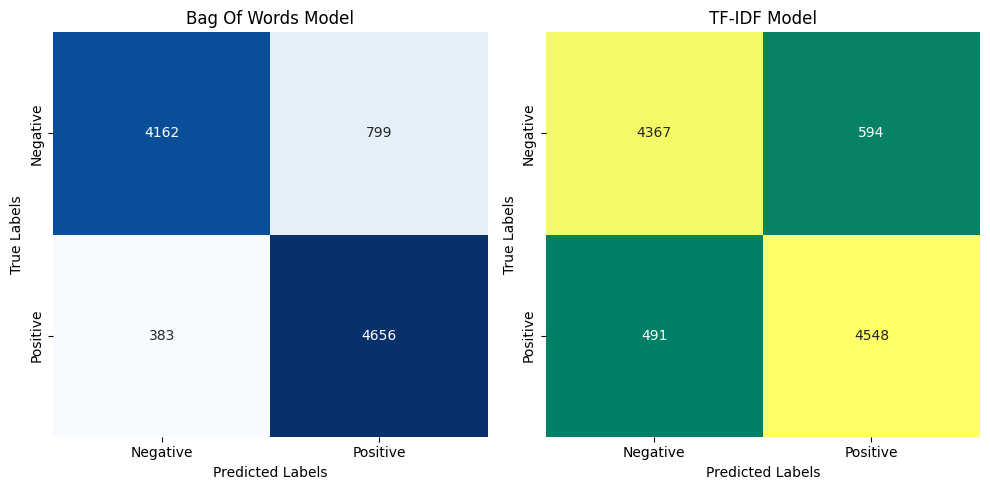

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Confusion matrix for Bag Of Words model
cm_cv = confusion_matrix(test_sentiments, test_pred_cv_svm)
sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axs[0])
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('True Labels')
axs[0].set_title('Bag Of Words Model')

# Confusion matrix for TF-IDF model
cm_tf = confusion_matrix(test_sentiments, test_pred_tf_svm)
sns.heatmap(cm_tf, annot=True, fmt='d', cmap='summer', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axs[1])
axs[1].set_xlabel('Predicted Labels')
axs[1].set_ylabel('True Labels')
axs[1].set_title('TF-IDF Model')

plt.tight_layout()
plt.show()

## Baseline Models and Comparison

In [33]:
import random
from sklearn.metrics import accuracy_score
train_sentiments = train_sentiments.ravel()
test_sentiments = test_sentiments.ravel()

# Majority label baseline model
majority_label = np.bincount(train_sentiments).argmax()
print(f"Majority label: {majority_label}")
test_pred_majority = np.full_like(test_sentiments, fill_value=majority_label)
accuracy_majority = accuracy_score(test_sentiments, test_pred_majority)
print(f"Accuracy for majority label baseline model: {accuracy_majority:.4f}")

# Random baseline model
random_labels = np.unique(train_sentiments)
test_pred_random = np.random.choice(random_labels, size=len(test_sentiments))
accuracy_random = accuracy_score(test_sentiments, test_pred_random)
print(f"Accuracy for random baseline model: {accuracy_random:.4f}")


Majority label: 0
Accuracy for majority label baseline model: 0.4961
Accuracy for random baseline model: 0.5012
